## 1.2 Train Simple Neural Network using Pytorch on MNIST Dataset
- About MNIST Dataset
- Load and Split Dataset Split
- Label Encoding
- Create Simple Neural Network Model
- Run Training Model
- Visualize Training Loss vs Trining Accuracy

In [ ]:
!pip install gdown

import os
import cv2
import gdown
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import transforms

from IPython import display

# clear output cell
display.clear_output()

print(f"torch : {torch.__version__}")
print(f"torch vision : {torchvision.__version__}")

torch : 2.4.1+cu121
torch vision : 0.19.1+cu121


### 1.2.1 About MNIST Dataset
- We will use the **MNIST dataset**, a collection of **60,000** labeled handwritten digits dataset in 10 classes.<br>
- Handwritten digits in the MNIST dataset are <i><font color='orange'>28x28 pixel</font></i> grayscale images.
- The neural network we will build <i><font color='orange'>classifies the handwritten digits</font></i> in their **10 classes** (0, .., 9).
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/MNIST.png?raw=1" width="700px">

- We will use sample dataset [mnist_dataset.zip](https://drive.google.com/file/d/1-FfwJrllyHofQwIbMb_IxAkxnfMGSFmR/view) from GDrive.
- If you want to use **your own dataset**, just upload dataset to GDrive and share as **public link** in **ZIP** format.<br>
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/gd-share.png?raw=1" width="400px">
- Open the shared link in browser, and copy the `GDrive ID` in browser address bar.<br>
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/gd-id.png?raw=1" width="600px"><br><br>
- Paste the GDrive ID as value `gdrive_id` variable below,

In [ ]:
DATASET_NAME = 'MNIST' # the dataset name
DATASET_NUM_CLASS = 10 # number of class in dataset

In [ ]:
# default using gdrive_id Dataset `mnist_dataset.zip` (1-FfwJrllyHofQwIbMb_IxAkxnfMGSFmR)
gdrive_id = '1-FfwJrllyHofQwIbMb_IxAkxnfMGSFmR' # <-----  ⚠️⚠️⚠️ USE YOUR OWN GDrive ID FOR CUSTOM DATASET ⚠️⚠️⚠️

# download zip from GDrive
url = f'https://drive.google.com/uc?id={gdrive_id}'
gdown.download(url, DATASET_NAME + ".zip", quiet=False)

# unzip dataset
!unzip {DATASET_NAME}.zip -d {DATASET_NAME}

# clear output cell
display.clear_output()

### 1.2.2 Load & Split Dataset
- Load each image on MNIST dataset using OpenCV
- <i><font color='orange'>Convert to gray</font></i>, to make sure we only have single channel of 28x28 pixel data on each image
- The simplest approach for classifying them is to use the <i><font color='orange'>28x28=784 pixels</font></i> as inputs for a 1-layer neural network.
- That why we will convert the <i><font color='orange'>2D matrix of 28x28 pixel</font></i> into flatten <i><font color='orange'>1D array 784 pixel</font></i>.<br>
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/MNIST_Load.png?raw=1" width="600px">

In [ ]:
# Define Custom Dataset class
# it's just helper to load image dataset using OpenCV and convert to pytorch tensor
# also doing a label encoding using one-hot encoding
class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = transforms.Compose([transforms.ToTensor()]) # initialize converter input image to pytorch tensor
        self.image_files = sorted([file for file in os.listdir(root_dir) if file.lower().endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read image from corresponding .png file
        image_path = os.path.join(self.root_dir, self.image_files[idx])
        image = cv2.imread(image_path)  # Load image using OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert BGR to GRAY
        if self.transform:
            image = self.transform(image) # apply convert input image to pytorch tensor

        # Read label from corresponding .txt file
        label_path = os.path.splitext(image_path)[0] + ".txt"
        with open(label_path, 'r') as label_file:
            label = int(label_file.read().strip())  # Assuming labels are integers

        # Flatten Image in 2D Tensor (28x28) into a 1D tensor (784)
        image = torch.flatten(image)

        # Apply one-hot encoding into label
        labels_tensor = torch.tensor(label)
        one_hot_encoded = F.one_hot(labels_tensor, num_classes=DATASET_NUM_CLASS).to(torch.float32)
        return image, one_hot_encoded



# instantiate dataset
# in here the image dataset is not loaded yet
# we only read all image files names in fataset folder
all_train_dataset = CustomDataset(root_dir=f'{DATASET_NAME}/dataset/train')
test_dataset = CustomDataset(root_dir=f'{DATASET_NAME}/dataset/test')

- Neural Network learned through a training process which requires a <i><font color='orange'>"training dataset"</font></i>.
- We <i><font color='cyan'>need another dataset, never seen during training</font></i>, to evaluate the "real-world" performance of the network. It is called an <i><font color='orange'>"validation dataset"</font></i>.
- Here we split the 60.000 labeled images MNIST dataset into <i><font color='orange'>60.000 data</font></i> for <i><font color='orange'>"training dataset"</font></i> and <i><font color='orange'>10.000 data</font></i> for <i><font color='orange'>"validation dataset"</font></i> <br>
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/MNIST_split.png?raw=1" width="600px">

In [ ]:
print(f"All Train Dataset : {len(all_train_dataset)} data")
print(f"Test Dataset : {len(test_dataset)} data")

All Train Dataset : 60000 data
Test Dataset : 10000 data


In [ ]:
# Split 'all_train_dataset' into 'train' and 'validation' set using `random_split()` function
train_dataset, validation_dataset = random_split(all_train_dataset, [50000, 10000])

print(f"Train Dataset : {len(train_dataset)} data")
print(f"Validation Dataset : {len(validation_dataset)} data")

Train Dataset : 50000 data
Validation Dataset : 10000 data


- As you can see above, we here split the MNIST dataset into 3 part, <i><font color='orange'>training set</font></i>, <i><font color='orange'>validation set</font></i> and <i><font color='orange'>test set</font></i>.
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/dataset_proportion.jpeg?raw=1" width="600px"><br>
- <i><font color='orange'>Training set</font></i> : is used in training phase, with size : 50.000 labeled MNIST digit
- <i><font color='orange'>Validation set</font></i> : is used for validationg model during training, for example Cross Validation, with size : 10.000 labeled MNIST digit
- <i><font color='orange'>Test set</font></i> : is used in testing phase (after training model finish), with size : 10.000 labeled MNIST digit

- `train_dataset`, `validation_dataset` and `test_dataset` is instantiated object, doesn't really load the dataset image files.
- to load the image files, we use pytorch `DataLoader()` load dataset into a small chunk in a `batch_size`
- `batch_size` is the number of samples used in `one forward` and `backward pass` through the network.
- this helping us to avoid loading the entire dataset into RAM at once
- imagine if we have very large dataset and might not fit in available RAM that we have

In [ ]:
# Create data loaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 1.2.3 Label Encoding
- Label Encoding help model to map label as <i><font color='orange'>numerical representation</font></i> with ordering.
- Model might learn some <i><font color='orange'>natural ordering between the different class labels</font></i> based on the labels.
- Assigning them <i><font color='orange'>numbers in a scale</font></i> would implicitly create ordering and relations between different classes.
- For this purpose, we will use <i><font color='orange'>One-hot Encoding</font></i> to encode label of MNIST dataset into look like this,<br>
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/MNIS_OneHot.png?raw=1" width="600px">

In [ ]:
# implementation is already applied in CustomDataset() class above
# here we try to explain how it's work

# for example we have label = 2 and label = 6
label = 2

# convert ot tensor
tensor_label = torch.tensor(label)

# apply one-hot encoding for number of class = 10
encoded_label = F.one_hot(tensor_label, num_classes=10)

print(f"Label : {label}")
print(f"Encoded Label : {encoded_label}")

Label : 2
Encoded Label : tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])


### 1.2.4 Create Simple Neural Network Model
- We will creating a simple Neural Network model, with only Input and Output Layer
- The <i><font color='cyan'>Input Layer</font></i> will have <i><font color='orange'>784</font></i> neuron (*same size with flattened 28x28=784 pixels on each MNIST dataset*)
- The <i><font color='cyan'>Output Layer</font></i> will have <i><font color='orange'>10 neuron</font></i> (*same size with a number of dataset class*)<br>
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/NN_SingleDense.png?raw=1" width="600px">


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a simple model
model = nn.Sequential(
    nn.Linear(in_features=784, out_features=10),  # 10 classes (digits 0-9)
    nn.LogSoftmax(dim=1)  # Log probabilities for classification
).to(device)


- Each "neuron" in a neural network does a <i><font color='cyan'>weighted sum of all of its inputs</font></i>, adds a constant called the <i><font color='cyan'>"bias"</font></i>.
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/NN_03.png?raw=1" width="300px"><br><br>
- On above network will have <i><font color='cyan'>784x10 weight</font></i>.<br>
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/NN_WeightedSum.gif?raw=1" width="600px"><br><br>
- Then feeds the result through some non-linear <i><font color='cyan'>"activation function"</font></i>. <br>
- We will use <i><font color='cyan'>Softmax</font></i> for that purpose.<br>
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/NN_08.png?raw=1" height="175px"><img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/NN_07.gif?raw=1" height="175px"><br><br>

- Then to <i><font color='cyan'>measure how good</font></i> the trained model, we will measure distance between what the <i><font color='cyan'>network tells us</font></i> and the <i><font color='cyan'>correct answers</font></i>.
- For classification problems we will use <i><font color='cyan'>"cross-entropy distance"</font></i> (a.k.a loss function).
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/NN_LOSS.png?raw=1" width="600px"><br><br>
- <i><font color='cyan'>"Training"</font></i> model actually means using training images and labels to <i><font color='cyan'>adjust weights</font></i> and <i><font color='cyan'>biases</font></i> so as to <i><font color='cyan'>minimise</font></i> the <i><font color='cyan'>cross-entropy</font></i> loss function.
- That process is called <i><font color='cyan'>Optimizer</font></i>. We will talk more about this in <i><font color='cyan'>Pertemuan 2</font></i>, but keep in mind we will use <i><font color='orange'>SGD Optimizer</font></i> for now.<br><br>
- We are also able to add metric to measure like model accuracy, precission, recall, or etc.
- For now we just use <i><font color='orange'>accuracy metric</font></i>.

In [ ]:
# setup optimizer, loss function & metric
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

### 1.2.5 Run Training Model
- To run training process, we can use the following code

In [ ]:
!pip install tqdm

from tqdm import tqdm

In [ ]:
def train(model, train_loader, optimizer, loss_function):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Add progress bar for training loop
    progress_bar = tqdm(train_loader, desc='Training', leave=False)

    for inputs, labels in progress_bar:
        # resets the gradients of all the model's parameters before the backward pass
        optimizer.zero_grad()
        # pass input tensor to model
        outputs = model(inputs)
        # calc loss value
        loss = loss_function(outputs, labels)
        # computes the gradient of the loss with respect to each parameter in model
        loss.backward()
        # adjust model parameter
        optimizer.step()
        # sum loss value
        running_loss += loss.item()

        # Calculate correct & total prediction
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels.argmax(1)).sum().item()
        total_predictions += labels.size(0)

        # Update progress bar description with current loss
        progress_bar.set_postfix(loss=loss.item())

    # Calculate average training loss
    average_train_loss = running_loss / len(train_loader.dataset)
    # Calculate training accuracy
    train_accuracy = correct_predictions / total_predictions
    return average_train_loss, train_accuracy

def validate(model, val_loader, loss_function):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Add progress bar for validation loop
    progress_bar = tqdm(val_loader, desc='Validating', leave=False)

    with torch.no_grad():
        for inputs, labels in progress_bar:
            # pass input tensor to model
            outputs = model(inputs)
            # calc loss value
            loss = loss_function(outputs, labels)
            # sum loss value
            running_loss += loss.item()

            # Calculate correct & total prediction
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels.argmax(1)).sum().item()
            total_predictions += labels.size(0)

            # Update progress bar description with loss
            progress_bar.set_postfix(loss=loss.item())

    # Calculate average validation loss
    average_val_loss = running_loss / len(val_loader.dataset)
    # Calculate validation accuracy
    val_accuracy = correct_predictions / total_predictions
    return average_val_loss, val_accuracy





# This is a training loop for selected Epoch
# each epoch will process all training and validation set, chunked into small batch size data
# then measure the loss & accuracy of training and validation set
NUM_EPOCH = 10      # you can change this value

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCH):
    print(f"Epoch {epoch+1}/{NUM_EPOCH}")

    train_loss, train_accuracy = train(model, train_loader, optimizer, loss_function)
    val_loss, val_accuracy = validate(model, validation_loader, loss_function)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy * 100)  # convert to percentage
    val_accuracies.append(val_accuracy * 100)  # convert to percentage

    print(f"Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, Val Accuracy = {val_accuracy:.4f}\n")

Epoch 1/10


Train Loss = 0.0042, Val Loss = 0.0046, Train Accuracy = 0.9250, Val Accuracy = 0.9147


Epoch 2/10


Train Loss = 0.0042, Val Loss = 0.0046, Train Accuracy = 0.9249, Val Accuracy = 0.9161


Epoch 3/10


Train Loss = 0.0041, Val Loss = 0.0046, Train Accuracy = 0.9253, Val Accuracy = 0.9157


Epoch 4/10


Train Loss = 0.0041, Val Loss = 0.0046, Train Accuracy = 0.9254, Val Accuracy = 0.9167


Epoch 5/10


Train Loss = 0.0041, Val Loss = 0.0046, Train Accuracy = 0.9265, Val Accuracy = 0.9174


Epoch 6/10


Train Loss = 0.0041, Val Loss = 0.0046, Train Accuracy = 0.9268, Val Accuracy = 0.9156


Epoch 7/10


Train Loss = 0.0040, Val Loss = 0.0045, Train Accuracy = 0.9272, Val Accuracy = 0.9182


Epoch 8/10


Train Loss = 0.0040, Val Loss = 0.0046, Train Accuracy = 0.9272, Val Accuracy = 0.9150


Epoch 9/10


Train Loss = 0.0040, Val Loss = 0.0046, Train Accuracy = 0.9279, Val Accuracy = 0.9156


Epoch 10/10


Train Loss = 0.0040, Val Loss = 0.0046, Train Accuracy = 0.9277, Val Accuracy = 0.9132




- <i><font color='orange'>Increase</font></i> number of <i><font color='orange'>batch size</font></i> impacting to <i><font color='orange'>number of iteration</font></i> need to process all training set.
- <i><font color='orange'>Bigger Batch Size</font></i> is <i><font color='orange'>faster in Training Time</font></i>, but require <i><font color='orange'>more Compute & Memory</font></i> more data loaded in single batch.
- Other advantages is adding <i><font color='orange'>model generalization</font></i>, making model more accurate for unseen dataset.<br>
<img src="https://github.com/Muhammad-Yunus/Belajar-Image-Classification/blob/main/Pertemuan%201/resource/BatchVsEpoch.png?raw=1" width="700px"><br>


### 1.2.6 Visualize Loss vs Accuracy
- We are also able to visualize Loss vs Accuracy using the following code,
- <i><font color='orange'>Loss will decrease</font></i> as the <i><font color='orange'>epoch increases</font></i>, whereas <i><font color='orange'>accuracy will increase</font></i>.

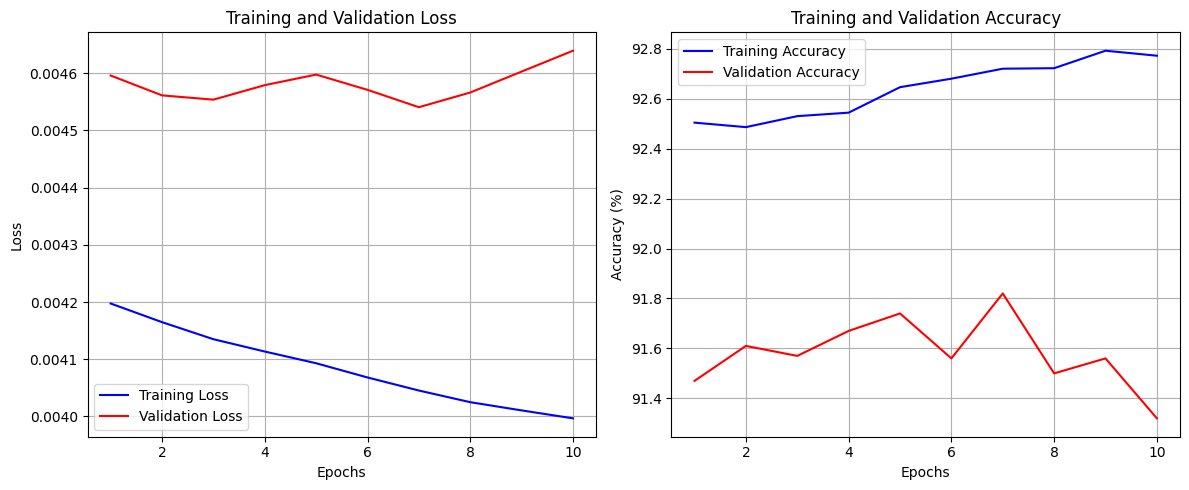

In [ ]:
# visualize Loss & Accuracy
import matplotlib.pyplot as plt

epochs = list(range(1, NUM_EPOCH + 1))

# Plotting loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()


### 1.2.7 Evaluate Model

- After we are finish with training model,
- we will now trying to `measure the performance of model` using `test set`
- We will use the `classification_report()` and `confusion_matrix()` from `sklearn` to visualize the prediction result over the `test set`

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.88      0.93      0.90      1010
           4       0.91      0.92      0.92       982
           5       0.90      0.86      0.88       892
           6       0.95      0.94      0.95       958
           7       0.92      0.93      0.93      1028
           8       0.89      0.85      0.87       974
           9       0.91      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



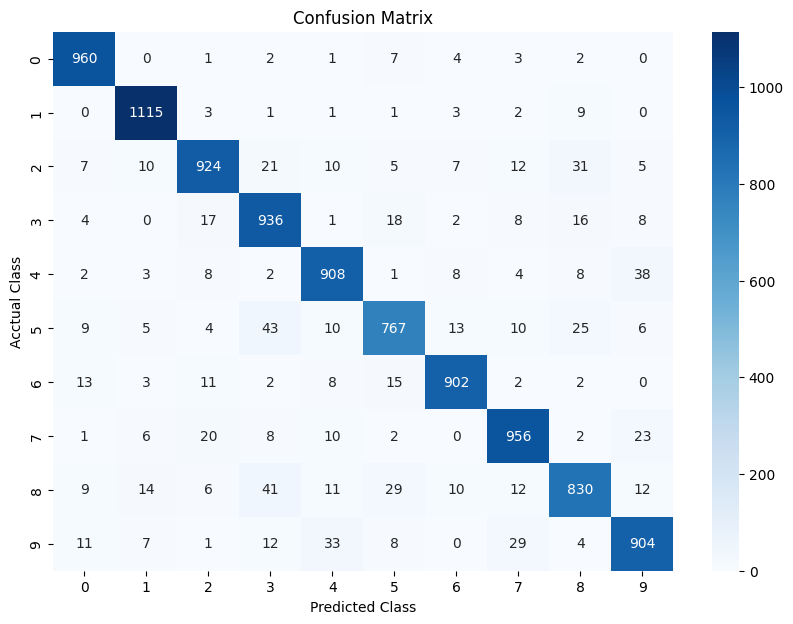

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# define evaluate function for test set
def evaluate(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    # Add progress bar for validation loop
    progress_bar = tqdm(test_loader, desc='Evaluating', leave=False)

    with torch.no_grad():
        # iterate over all batched test set
        for inputs, labels in progress_bar:
            # pass input tensor to model
            outputs = model(inputs)
            # get prediction
            _, preds = torch.max(outputs, 1)
            # collect all labels & preds
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

# Evaluation on test set
all_labels, all_preds = evaluate(model, test_loader)
all_labels = np.argmax(all_labels, axis=1)

# Calculate classification report
labels = [str(i) for i in range(DATASET_NUM_CLASS)]
print(classification_report(all_labels, all_preds, target_names=labels))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Class')
plt.ylabel('Acctual Class')
plt.title('Confusion Matrix')
plt.show()

### 1.2.7 Save Trained Model

In [25]:
# Save the model
torch.save(model.state_dict(), 'trained_model.pt')

# Download the model file
from google.colab import files
files.download('trained_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<br><br><br><br><br>
# Source
- https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist#2